In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

In [2]:
#!wget -nc -O IDMT_Traffic.zip "https://zenodo.org/records/7551553/files/IDMT_Traffic.zip?download=1"
#!unzip -n IDMT_Traffic.zip > /dev/null

zsh:1: command not found: wget
unzip:  cannot find or open IDMT_Traffic.zip, IDMT_Traffic.zip.zip or IDMT_Traffic.zip.ZIP.


In [2]:


def import_idmt_traffic_dataset_from_lines(lines) -> pd.DataFrame:
    """Importa e parsifica il dataset da una lista di nomi di file audio."""
    df_dataset = []

    for fn in lines:
        fn = fn.strip().replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK').replace('Kmh', '')

        df_dataset.append({
            'file': fn,
            'is_background': is_background,
            'date_time': date_time,
            'location': location,
            'speed_kmh': speed_kmh,
            'sample_pos': sample_pos,
            'daytime': daytime,
            'weather': weather,
            'vehicle': vehicle,
            'source_direction': source_direction,
            'microphone': mic,
            'channel': channel
        })

    df_dataset = pd.DataFrame(df_dataset)
    return df_dataset


In [3]:
import zipfile
import pandas as pd
from io import TextIOWrapper
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


ZIP_PATH = "/Volumes/Extreme SSD/IDMT_Traffic.zip"

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    all_audio_files = [f for f in zip_ref.namelist() if f.startswith("IDMT_Traffic/audio/") and f.endswith('.wav')]
    print(f"\nNumero totale di file audio trovati: {len(all_audio_files)}")

    # Leggi il file txt come lista di nomi file
    with zip_ref.open("IDMT_Traffic/annotation/idmt_traffic_all.txt") as ann_file:
        file_lines = TextIOWrapper(ann_file, 'utf-8').readlines()

# === Parsing con la tua logica ===
df_dataset = import_idmt_traffic_dataset_from_lines(file_lines)

# Debug
print(df_dataset.columns)
print(df_dataset.head(50))  # Mostra le prime 20 righe

df_5class = df_dataset[df_dataset['vehicle'].isin(['B', 'C', 'M', 'T', 'None'])].copy()

labels = df_5class['vehicle']
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_cat = to_categorical(labels_encoded)

# Mostra la mappatura
print("Classi codificate:", le.classes_)  # ['B', 'C', 'M', 'None', 'T']







Numero totale di file audio trovati: 17506
Index(['file', 'is_background', 'date_time', 'location', 'speed_kmh',
       'sample_pos', 'daytime', 'weather', 'vehicle', 'source_direction',
       'microphone', 'channel'],
      dtype='object')
                                                 file  is_background  \
0   2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...           True   
1   2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...           True   
2   2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...           True   
3   2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...           True   
4   2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1026944...           True   
5   2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1026944...           True   
6   2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1036544...           True   
7   2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1036544...           True   
8   2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1046144...           True   
9   2019-10-22-08-40_Fraunhofer-IDMT_

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import random

def load_stereo_wav_from_zip(zip_path, wav_filename):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(wav_filename) as wav_file:
            # carica audio stereo in memoria
            y, sr = librosa.load(wav_file, sr=None, mono=False)
            return y, sr
        

ZIP_PATH = "/Volumes/Extreme SSD/IDMT_Traffic.zip"


# Assumiamo che df_5class sia già definito (con vehicle in ['B','C','M','T','None'])
sample_df = df_5class.sample(5, random_state=42)  # selezione riproducibile

for i, row in sample_df.iterrows():
    print(f"{row['vehicle']} → {row['file']}")

sample_paths = ["IDMT_Traffic/audio/" + f + ".wav" for f in sample_df['file']]

def load_stereo_audio_from_zip(zip_path, internal_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(internal_path) as wav_file:
            y, sr = librosa.load(wav_file, sr=None, mono=False)
            return y, sr

for path in sample_paths:
    print(f"File: {path}")
    try:
        audio, sr = load_stereo_audio_from_zip(ZIP_PATH, path)
        display(Audio(audio[0], rate=sr))  # canale sinistro
    except Exception as e:
        print(f"Errore su {path}: {e}")


         

C → 2019-11-13-08-00_Schleusinger-Allee_70Kmh_608984_M_W_CL_SE_CH34
C → 2019-11-19-07-25_Langewiesener-Strasse_50Kmh_958160_M_D_CR_SE_CH34
None → 2019-10-23-08-35_Fraunhofer-IDMT_30Kmh_3284736_SE_CH34-BG
C → 2019-11-13-15-55_Schleusinger-Allee_70Kmh_1584322_A_D_CL_SE_CH34
None → 2019-11-19-15-25_Langewiesener-Strasse_50Kmh_86356224_SE_CH34-BG
File: IDMT_Traffic/audio/2019-11-13-08-00_Schleusinger-Allee_70Kmh_608984_M_W_CL_SE_CH34.wav


File: IDMT_Traffic/audio/2019-11-19-07-25_Langewiesener-Strasse_50Kmh_958160_M_D_CR_SE_CH34.wav


File: IDMT_Traffic/audio/2019-10-23-08-35_Fraunhofer-IDMT_30Kmh_3284736_SE_CH34-BG.wav


File: IDMT_Traffic/audio/2019-11-13-15-55_Schleusinger-Allee_70Kmh_1584322_A_D_CL_SE_CH34.wav


File: IDMT_Traffic/audio/2019-11-19-15-25_Langewiesener-Strasse_50Kmh_86356224_SE_CH34-BG.wav


**Inter-Channel Level Difference (ICLD) / Interaural Level Difference (ILD):**
Cosa misura: Differenza di energia tra i canali.
Come calcolarla: Calcola la potenza RMS o l’energia su una finestra e Prendi la differenza logaritmica in dB.



🎧 File selezionato: 2019-11-18-16-40_Langewiesener-Strasse_50Kmh_58817279_ME_CH12-BG (vehicle = None)


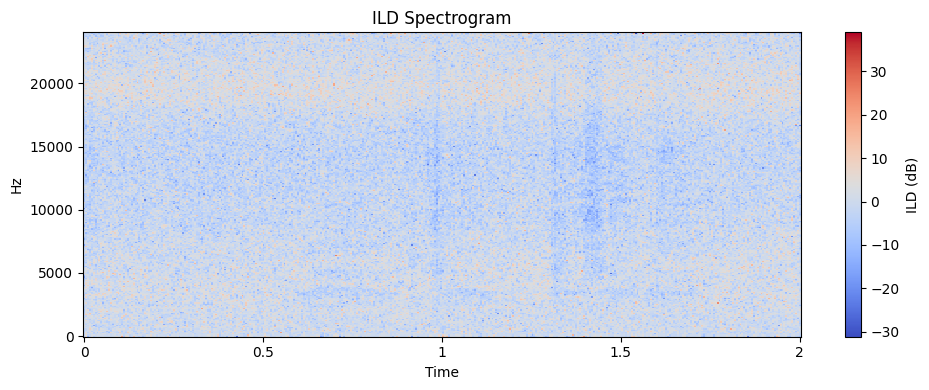

In [5]:
N_FFT = 512
HOP_LENGTH = 256

def compute_ild(ch1, ch2, n_fft=512, hop_length=256):
    """
    Calcola l'Interaural Level Difference tra due canali audio.
    """
    stft1 = librosa.stft(ch1, n_fft=n_fft, hop_length=hop_length)
    stft2 = librosa.stft(ch2, n_fft=n_fft, hop_length=hop_length)
    
    mag1 = np.abs(stft1)
    mag2 = np.abs(stft2)
    
    ild = 10 * np.log10((mag1 + 1e-8) / (mag2 + 1e-8))  # +epsilon per evitare divisione per 0
    return ild

# === 3. Visualizzazione ===
def plot_ild(ild, sr, hop_length, title="ILD Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(ild, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.title(title)
    plt.colorbar(label='ILD (dB)')
    plt.tight_layout()
    plt.show()

# === 4. Esegui su un file casuale ===

# Seleziona 1 file a caso con vehicle ≠ None
random_row = df_5class.sample(1).iloc[0]
filename = random_row['file']
internal_path = f"IDMT_Traffic/audio/{filename}.wav"

print(f"🎧 File selezionato: {filename} (vehicle = {random_row['vehicle']})")

# Carica audio stereo
audio, sr = load_stereo_audio_from_zip(ZIP_PATH, internal_path)

# Calcola ILD
ild = compute_ild(audio[0], audio[1], n_fft=N_FFT, hop_length=HOP_LENGTH)

# Visualizza
plot_ild(ild, sr, hop_length=HOP_LENGTH)

def play_audio(audio, sr, mode='mono'):
    if mode == 'mono':
        audio_out = (audio[0] + audio[1]) / 2
    elif mode == 'left':
        audio_out = audio[0]
    elif mode == 'right':
        audio_out = audio[1]
    else:
        raise ValueError("mode must be 'mono', 'left', or 'right'")
    
    return Audio(audio_out, rate=sr)

play_audio(audio, sr, mode='mono')

**Inter-Channel Phase Difference (IPD):**
Cosa misura: Differenze di fase tra canali per diverse frequenze.
Come usarla: Si ottiene tramite STFT (Short-Time Fourier Transform).

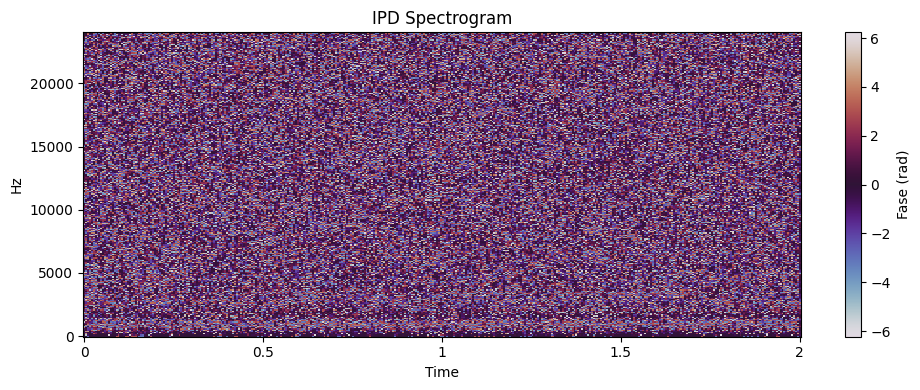

In [6]:
def compute_ipd(ch1, ch2, n_fft=512, hop_length=256):
    """
    Calcola l'Interaural Phase Difference tra due canali.
    """
    stft1 = librosa.stft(ch1, n_fft=n_fft, hop_length=hop_length)
    stft2 = librosa.stft(ch2, n_fft=n_fft, hop_length=hop_length)

    phase1 = np.angle(stft1)
    phase2 = np.angle(stft2)

    ipd = phase1 - phase2
    return ipd


def plot_ipd(ipd, sr, hop_length, title="IPD Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(ipd, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='twilight')
    plt.title(title)
    plt.colorbar(label='Fase (rad)')
    plt.tight_layout()
    plt.show()


ipd = compute_ipd(audio[0], audio[1], n_fft=N_FFT, hop_length=HOP_LENGTH)
plot_ipd(ipd, sr, hop_length=HOP_LENGTH)

In [7]:
spectograms = []
fixed_length = None

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    for audio_path in all_audio_files[:]:  # eventualmente [:100] per debug veloce
        with zip_ref.open(audio_path) as audio_file:
            # Caricamento stereo
            y, sr = librosa.load(audio_file, sr=None, mono=False)  # Carica 2 canali

            # Se l'audio non è stereo, salta
            if y.ndim != 2 or y.shape[0] != 2:
                continue

            left, right = y[0], y[1]

            # === Mel-spectrogram mono ===
            mono = (left + right) / 2
            mel_spec = librosa.feature.melspectrogram(y=mono, sr=sr)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # === ILD ===
            ild = compute_ild(left, right, n_fft=N_FFT, hop_length=HOP_LENGTH)

            # === IPD ===
            ipd = compute_ipd(left, right, n_fft=N_FFT, hop_length=HOP_LENGTH)

            # === Uniforma le dimensioni sul tempo (asse 1) ===
            min_frames = min(mel_spec_db.shape[1], ild.shape[1], ipd.shape[1])
            mel_spec_db = mel_spec_db[:, :min_frames]
            ild = ild[:, :min_frames]
            ipd = ipd[:, :min_frames]

            # === Ridimensiona mel spec se è più corto o lungo del riferimento ===
            if fixed_length is None:
                fixed_length = min_frames

            if mel_spec_db.shape[1] < fixed_length:
                pad_width = fixed_length - mel_spec_db.shape[1]
                mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
                ild = np.pad(ild, ((0, 0), (0, pad_width)), mode='constant')
                ipd = np.pad(ipd, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mel_spec_db = mel_spec_db[:, :fixed_length]
                ild = ild[:, :fixed_length]
                ipd = ipd[:, :fixed_length]

            # === Concatenazione lungo l'asse delle frequenze ===
            full_spec = np.concatenate([mel_spec_db, ild, ipd], axis=0)

            spectograms.append(full_spec)


In [19]:
#spectograms = []
#fixed_length = None

#with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
#    for audio_path in all_audio_files[:]:   #RIDOTTO A :100 IN MODO TALE CHE SIA TUTTO PIù VELOCE
#        with zip_ref.open(audio_path) as audio_file:
#            y, sr = librosa.load(audio_file, sr=None)  # sr=None per usare la frequenza originalàe
#
#            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
#            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
#
#            if fixed_length is None:
#                fixed_length = mel_spectrogram_db.shape[1]
#
#            if mel_spectrogram_db.shape[1] < fixed_length:
#                mel_spectrogram_db = np.pad(mel_spectrogram_db,
#                                            ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])),
#                                            mode='constant')
#            else:
#                mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]
#
#            spectograms.append(mel_spectrogram_db)


Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_seek at 0x30b5c4d30>:
Traceback (most recent call last):
  File "/Users/stefanoliera/miniconda3/lib/python3.8/site-packages/soundfile.py", line 1238, in vio_seek
    file.seek(offset, whence)
  File "/Users/stefanoliera/miniconda3/lib/python3.8/zipfile.py", line 1102, in seek
    self.read(read_len)
  File "/Users/stefanoliera/miniconda3/lib/python3.8/zipfile.py", line 940, in read
    data = self._read1(n)
  File "/Users/stefanoliera/miniconda3/lib/python3.8/zipfile.py", line 1016, in _read1
    data = self._decompressor.decompress(data, n)
KeyboardInterrupt: 
Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_read at 0x30b5c4f70>:
Traceback (most recent call last):
  File "/Users/stefanoliera/miniconda3/lib/python3.8/site-packages/soundfile.py", line 1246, in vio_read
    data_read = file.readinto(buf)
  File "/Users/stefanoliera/miniconda3/lib/python3.8/zipfile.

In [8]:
spectograms = np.array(spectograms)
spectograms = spectograms / np.max(np.abs(spectograms))
input_shape = spectograms.shape[1:]
print(spectograms.shape)
print(input_shape)

(17506, 642, 188)
(642, 188)


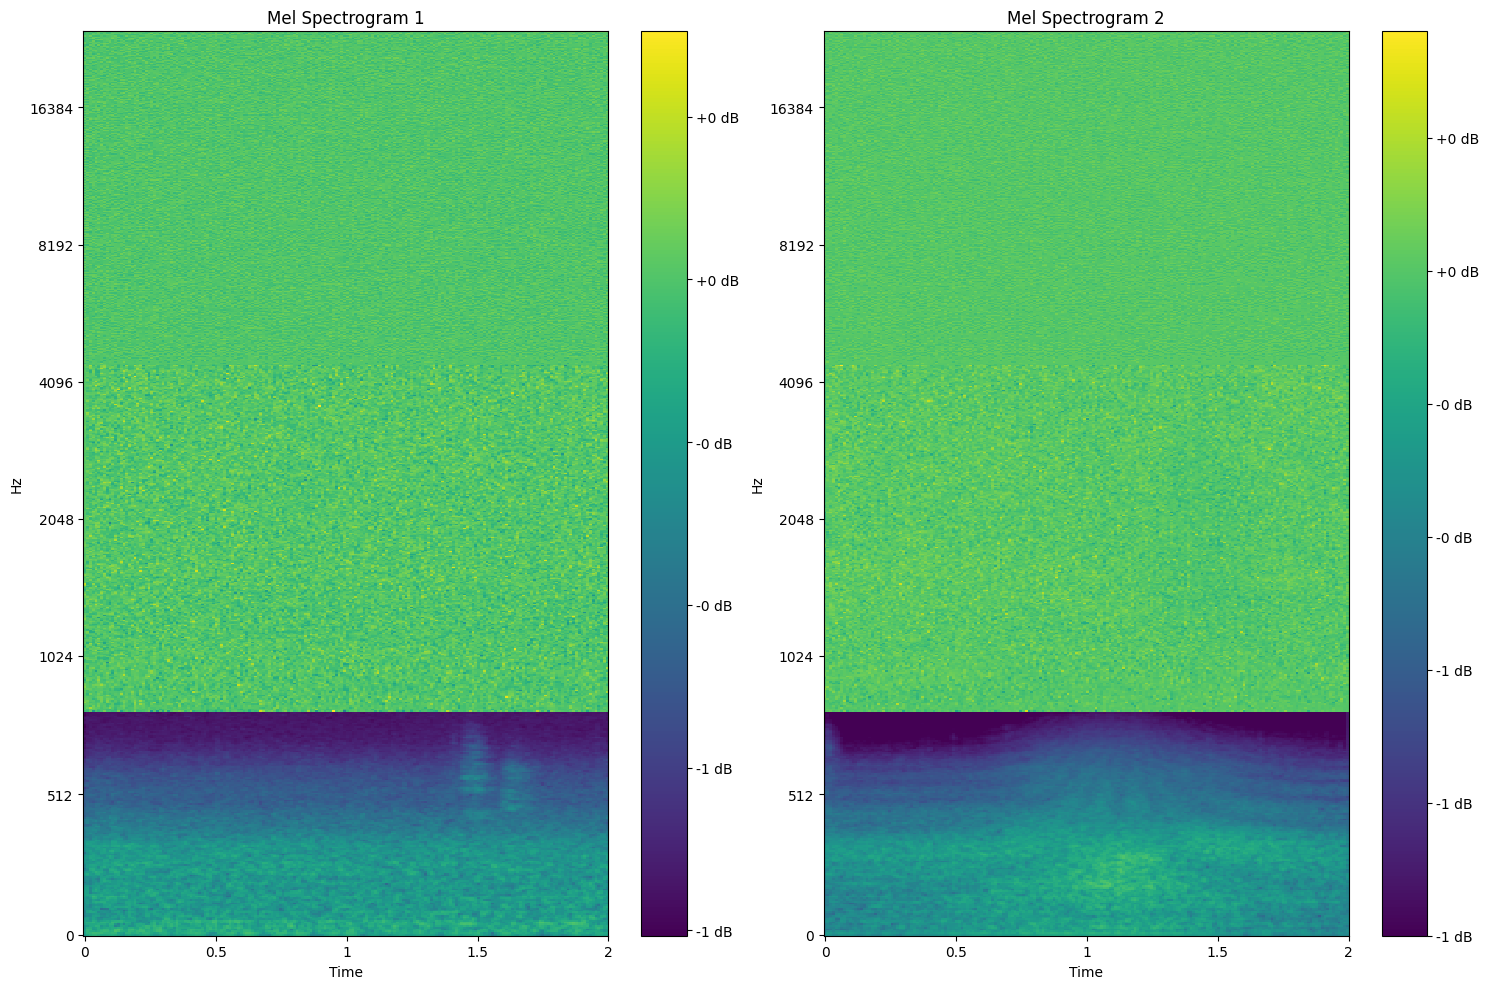

In [9]:
# visualization mel spectrogram

import matplotlib.pyplot as plt
import librosa.display

# Numero di spettrogrammi da visualizzare
n_to_plot = 2

plt.figure(figsize=(15, 10))

for i in range(n_to_plot):
    plt.subplot(1, n_to_plot, i + 1)
    librosa.display.specshow(spectograms[i], sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title(f"Mel Spectrogram {i+1}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

plt.show()

In [10]:
# Normalization and Padding

spectograms = []
fixed_length = None

def normalize_spectrogram(spec):
    spec_min = np.min(spec)
    spec_max = np.max(spec)
    return (spec - spec_min) / (spec_max - spec_min + 1e-6)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    for audio_path in all_audio_files[:]:
        with zip_ref.open(audio_path) as audio_file:
            y, sr = librosa.load(audio_file, sr=None)

            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            if fixed_length is None:
                fixed_length = mel_spectrogram_db.shape[1]

            # Padding o troncamento
            if mel_spectrogram_db.shape[1] < fixed_length:
                mel_spectrogram_db = np.pad(mel_spectrogram_db,
                                            ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])),
                                            mode='constant')
            else:
                mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]

            # Normalizzazione
            mel_spectrogram_db = normalize_spectrogram(mel_spectrogram_db)

            spectograms.append(mel_spectrogram_db)


            

In [13]:
# Data Augmentation 

#augmented_versions = []

def random_window(y, sr, window_duration=2.0):
    """Estrae una finestra casuale di durata fissa dal segnale audio."""
    window_length = int(window_duration * sr)
    if len(y) <= window_length:
        return np.pad(y, (0, window_length - len(y)), mode='constant')
    else:
        start = np.random.randint(0, len(y) - window_length)
        return y[start:start + window_length]


# Esempio di una funzione di augmentazione
def augment_audio(y, sr):
    versions = []

    # Applica Random Window di 2 secondi
    y_crop = random_window(y, sr, window_duration=2.0)

    # Originale (crocato)
    versions.append(y_crop)

    # Pitch shift
    versions.append(librosa.effects.pitch_shift(y_crop, sr=sr, n_steps=2))

    # Time stretch
    y_stretched = librosa.effects.time_stretch(y_crop, rate=1.2)
    if len(y_stretched) > len(y_crop):
        y_stretched = y_stretched[:len(y_crop)]
    else:
        y_stretched = np.pad(y_stretched, (0, len(y_crop) - len(y_stretched)), mode='constant')
    versions.append(y_stretched)

    # Rumore
    versions.append(add_noise(y_crop, snr_db=10))

    # Impulse response (opzionale)
    # ir, _ = librosa.load('impulse_response.wav', sr=sr)
    # ir = ir / np.sqrt(np.sum(ir**2))
    # y_reverb = fftconvolve(y_crop, ir, mode='full')[:len(y_crop)]
    # versions.append(y_reverb)

    return versions




In [14]:
# Dataset Split

from sklearn.model_selection import train_test_split

# Supponiamo che ogni spettrogramma abbia una label associata
# Per ora creiamo un placeholder per le label (es. 0, 1, 2,...)
labels = np.arange(len(spectograms))  # sostituisci con le vere label se le hai

# Primo split: Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    spectograms, labels, test_size=0.30, random_state=42, shuffle=True)

# Secondo split: Temp in Validation (15%) + Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True)

print(f"Train set: {len(X_train)} campioni")
print(f"Validation set: {len(X_val)} campioni")
print(f"Test set: {len(X_test)} campioni")




#FINISCE QUI



Train set: 12254 campioni
Validation set: 2626 campioni
Test set: 2626 campioni


In [8]:
model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(spectograms.shape[1], spectograms.shape[2], 1)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

AttributeError: 'list' object has no attribute 'shape'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    spectograms, labels_cat, test_size=0.6, stratify=labels_encoded, random_state=42
)

ValueError: Found input variables with inconsistent numbers of samples: [100, 17506]

In [32]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.4773 - loss: 1.0035 - val_accuracy: 0.4653 - val_loss: 1.0049
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.4523 - loss: 0.9961 - val_accuracy: 0.4653 - val_loss: 1.0050
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.4641 - loss: 0.9957 - val_accuracy: 0.4653 - val_loss: 1.0047
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.4551 - loss: 1.0037 - val_accuracy: 0.4653 - val_loss: 1.0042
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.4620 - loss: 1.0241 - val_accuracy: 0.4653 - val_loss: 1.0072


NameError: name 'history' is not defined

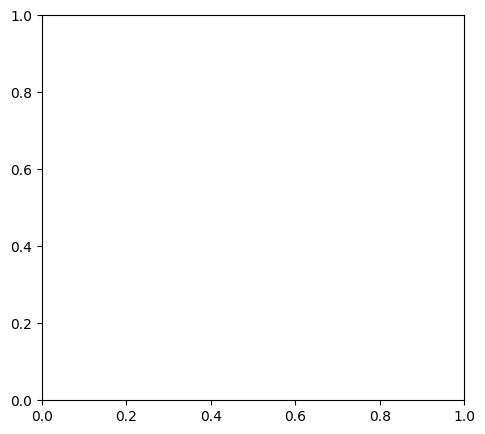

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()